In [1]:
# import the main program and all the functions i created
from main import *

# Suppress warnings 
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
plt.style.use('fivethirtyeight')
#sns.set()
#pd.options.display.max_columns = 100

In [2]:
# Run once to generat the data / else: load data from the csv

# option 1
#data = main()

# option 2
data = pd.read_csv('main.csv')

In [3]:
data.head()
data.shape
type(data)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(307507, 797)

pandas.core.frame.DataFrame

In [4]:
data = remove_missing_columns(data)
missing_values = missing_values_table(data.copy())
missing_values

# free memory 
gc.enable()
del missing_values
gc.collect()

data = remove_missing_columns(data)

There are 37 columns with greater than 80% missing values.
Your selected dataframe has 760 columns.
There are 579 columns that have missing values.


,Missing Values,% of Total Missing Values
CLOSED_AMT_ANNUITY_MAX,241498,78.5
CLOSED_AMT_ANNUITY_MEAN,241498,78.5
ACTIVE_MONTHS_BALANCE_MAX_MAX,230988,75.1
ACTIVE_MONTHS_BALANCE_SIZE_MEAN,230988,75.1
ACTIVE_MONTHS_BALANCE_MIN_MIN,230988,75.1
...,...,...
PAYMENT_RATE,12,0.0
AMT_ANNUITY,12,0.0
INCOME_PER_PERSON,2,0.0
CNT_FAM_MEMBERS,2,0.0


0

There are 0 columns with greater than 80% missing values.


In [5]:
# take some data
data_cut = data
#data_cut = data.sample(30_000).copy()


# replace all inifity values with maximum finite float64 values
data_cut.replace([np.inf, -np.inf], np.nan, inplace=True)

# free memory 
# gc.enable()
# del data
# gc.collect()

In [6]:
# fill NaN values with 0
data_cut.fillna(0,inplace=True)

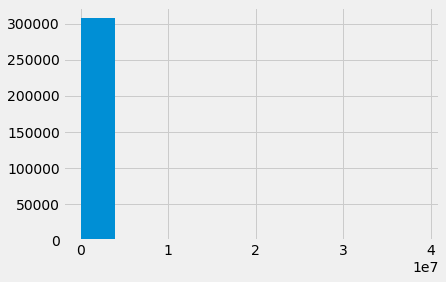

In [7]:
data_cut['INCOME_PER_PERSON'].hist()

In [8]:
# Process outliers
data_cut = outliers_transformer(data_cut)

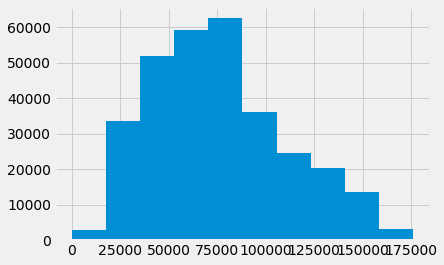

In [9]:
data_cut['INCOME_PER_PERSON'].hist()

In [10]:
# calculate the the scale_post_weight parameter for xgboost to give more importance for minority class
positive_class = len(data_cut[data_cut['TARGET']==0])
negative_class = len(data_cut[data_cut['TARGET']==1])
xgboost_blance_param = positive_class/negative_class
xgboost_blance_param

11.386988922457201

In [11]:
# #instantiate XGB Classifier
xgbr = xgb.XGBClassifier(eta=0.05,max_depth=8,min_child_weight=30,subsample=0.85,colsample_bylevel=0.632,colsample_bytree=0.7,nrounds=200,n_estimators=1000,n_jobs=-1,objective='binary:logistic',eval_metric='auc', scale_pos_weight=xgboost_blance_param, verbosity=1, gamma=0.1)


# Hyper Parameter Optimization
# params = {
    
#     "nthread" : [4],
#     "eta" : [0.05],
#     "max_depth" : [6],
#     "min_child_weight" :[ 30],
#     "gamma" : [0],
#     "subsample" :[ 0.85],
#     "colsample_bytree" : [0.7],
#     "colsample_bylevel" : [0.632],
#     "alpha" : [0],
#     "lambda" : [0],
#     "nrounds" : [200]
        #   }

#random_search = GridSearchCV(xgbr,
                                #    param_grid=params,
                                #    scoring='roc_auc',
                                #    n_jobs=-1,cv=3,verbose=3)

In [12]:
# # Prepare data to run rhe model
X = data_cut.drop(['TARGET','SK_ID_CURR'],axis=1).copy()
y = data_cut['TARGET'].copy()



startify_param = data_cut['TARGET']
#split data into train,test (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=startify_param, random_state=7)

# Standardization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgbr.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], eval_metric='auc', early_stopping_rounds=5)

#random_search.fit(X_train_scaled,y_train)
# y_pred_test = random_search.predict(X_test_scaled)
# y_pred_train = random_search.predict(X_train_scaled)

# best_model = random_search.best_estimator_


[0]	validation_0-auc:0.67454
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.68957
[2]	validation_0-auc:0.69741
[3]	validation_0-auc:0.70288
[4]	validation_0-auc:0.70524
[5]	validation_0-auc:0.70726
[6]	validation_0-auc:0.71185
[7]	validation_0-auc:0.71311
[8]	validation_0-auc:0.71401
[9]	validation_0-auc:0.71651
[10]	validation_0-auc:0.71741
[11]	validation_0-auc:0.71783
[12]	validation_0-auc:0.71834
[13]	validation_0-auc:0.72002
[14]	validation_0-auc:0.72025
[15]	validation_0-auc:0.72204
[16]	validation_0-auc:0.72235
[17]	validation_0-auc:0.72296
[18]	validation_0-auc:0.72403
[19]	validation_0-auc:0.72557
[20]	validation_0-auc:0.72635
[21]	validation_0-auc:0.72660
[22]	validation_0-auc:0.72641
[23]	validation_0-auc:0.72721
[24]	validation_0-auc:0.72789
[25]	validation_0-auc:0.72860
[26]	validation_0-auc:0.72852
[27]	validation_0-auc:0.72907
[28]	validation_0-auc:0.72924
[29]	validation_0-auc:0.72939
[30]	validation_0-auc:0.72973
[31]	validation_0

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.632,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.05,
              eval_metric='auc', gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.0500000007,
              max_delta_step=0, max_depth=8, min_child_weight=30, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              nrounds=200, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=11.386988922457201, subsample=0.85,
              tree_method=None, validate_parameters=False, verbosity=1)

train score: 0.7872289823277305
test score: 0.7537594355426792


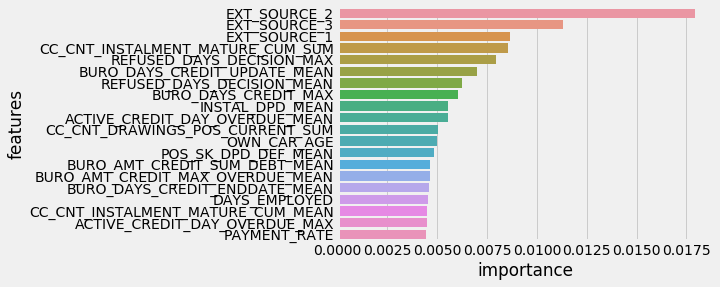

In [13]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import r2_score

y_pred_train = xgbr.predict(X_train_scaled)
y_pred_test = xgbr.predict(X_test_scaled)
print("train score:", accuracy_score(y_train,y_pred_train))
print("test score:", accuracy_score(y_test,y_pred_test))
important_features = print_importance_features(xgbr, X_train.columns,num_features=20 )

In [14]:
# plot confusion matrix and classification report 
confusion_matrix(y_pred_test, y_test)
print ('Confusion Matrix :')
print(y_pred_test) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred_test)) 
print ('Report : ')
print (classification_report(y_test, y_pred_test))


array([[71691,  3393],
       [21595,  4799]], dtype=int64)

Confusion Matrix :
[0 0 0 ... 0 0 0]
Accuracy Score : 0.7537594355426792
Report : 
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     93286
           1       0.18      0.59      0.28      8192

    accuracy                           0.75    101478
   macro avg       0.57      0.68      0.56    101478
weighted avg       0.89      0.75      0.81    101478



## create dataframe with probabilities score and predicted class for Streamlit APP

In [15]:
score_predicted = xgbr.predict_proba(X_train_scaled)[:,1]
score_predicted

array([0.38273335, 0.10411421, 0.17462316, ..., 0.41531512, 0.20177223,
       0.22234182], dtype=float32)

In [16]:
predicted_class = y_pred_train

In [17]:
target_merge = data_cut['TARGET']
streamlit_data = X_train.merge(target_merge, left_index=True, right_index=True)

In [18]:
id_merge = data_cut['SK_ID_CURR']
streamlit_data = streamlit_data.merge(id_merge, left_index=True, right_index=True)

In [19]:
streamlit_data['SK_ID_CURR'] = streamlit_data['SK_ID_CURR'].astype(int)
(streamlit_data['SK_ID_CURR'].dtype)

dtype('int32')

In [20]:
streamlit_data['score'] = score_predicted
streamlit_data['predicted_class'] = predicted_class

In [21]:
streamlit_data
streamlit_data.sample(10_000).to_csv('streamlit_data.csv', index=False)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,TARGET,SK_ID_CURR,score,predicted_class
41037,1.0,0.0,0.0,0.0,225000.0,513531.0,31653.0,450000.0,0.008019,-15542.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,278203,0.382733,0
246081,1.0,0.0,0.0,0.0,90000.0,270000.0,13500.0,270000.0,0.009657,-15750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,278203,0.104114,0
13054,1.0,0.0,0.0,0.0,126000.0,513531.0,31653.0,450000.0,0.018801,-14325.0,...,0.0,0.0,0.0,0.0,0.0,24.0,0,278203,0.174623,0
4405,1.0,0.0,0.0,0.0,180000.0,269982.0,30663.0,238500.0,0.014464,-15750.0,...,0.0,0.0,0.0,0.0,0.0,11.0,0,278203,0.669098,1
95829,1.0,0.0,0.0,0.0,360000.0,513531.0,24903.0,450000.0,0.006233,-16645.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,211252,0.079703,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178869,1.0,0.0,0.0,0.0,157500.0,513531.0,36423.0,450000.0,0.014520,-15040.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,307282,0.352178,0
249788,1.0,0.0,0.0,0.0,63000.0,269550.0,13761.0,225000.0,0.011703,-15750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,278203,0.449852,0
9585,1.0,0.0,0.0,0.0,81000.0,135000.0,24903.0,135000.0,0.018209,-15750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,278203,0.415315,0
137085,1.0,0.0,0.0,0.0,157500.0,808650.0,26217.0,675000.0,0.020713,-15750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,258998,0.201772,0


# serialize the model

In [26]:
# serialize the model, and scaler

joblib.dump(xgbr,'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['model.pkl']

['scaler.pkl']

## create some json files to test the api

In [23]:
X_test[:5].to_json('test_json3.json', orient='records')